img stats, mean: 112.284, std: 26.889, median: 120.000


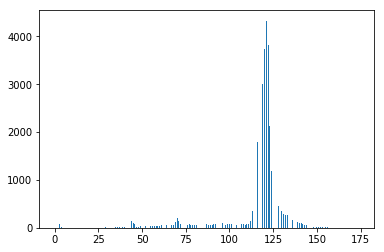

c:\users\rdiersin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
c:\users\rdiersin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


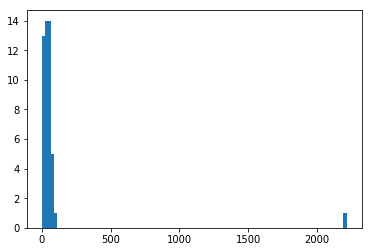

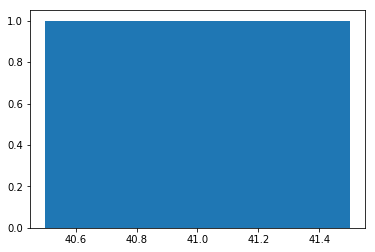

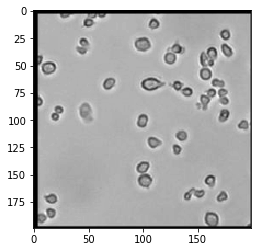

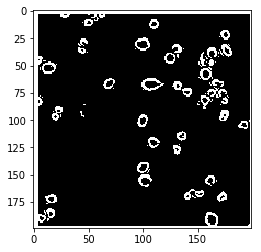

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


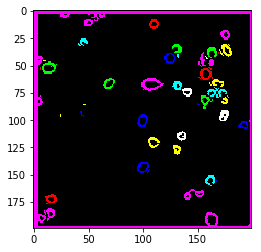

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import cv2
import queue

def getNeighbors(img, point):
    neighbors = []
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            n = (point[0] + i, point[1] + j)
            if n[0] > 0 and n[0] < img.shape[0] and n[1] > 0 and n[1] < img.shape[1]:
                neighbors.append(n)
    return neighbors

img = cv2.imread('stock_cells1.png',0).astype(np.float32)

img_flat = np.ndarray.flatten(img)
print('img stats, mean: %.3f, std: %.3f, median: %.3f' % (img_flat.mean(), img_flat.std(), np.median(img_flat)))
plt.hist(img_flat, bins='auto')
plt.show()
img_median = np.median(img_flat)

threshold = 0.25
img_threshold = np.copy(img)
img_threshold[np.abs(img - img_median) <= threshold * img_median] = 0
img_threshold[np.abs(img - img_median) > threshold * img_median] = 256

img_bfs = np.copy(img_threshold)

cell_sets = []
found_points = set()
q = queue.Queue()
for i in range(img_bfs.shape[0]):
    for j in range(img_bfs.shape[1]):
        point = (i, j)
        if img_bfs[point] != 256 or point in found_points:
            continue
            
        q.put(point)
        cell_set = set()
        cell_set.add(point)
        while not q.empty():
            curr = q.get()
            
            for neighbor in getNeighbors(img_bfs, curr):
                if neighbor not in found_points and img_bfs[neighbor] == 256:
                    found_points.add(neighbor)
                    q.put(neighbor)
                    cell_set.add(neighbor)
        cell_sets.append(cell_set)
        
img_color = np.zeros([img.shape[0], img.shape[1], 3])
i = 0
cset_stats = []
for cset in cell_sets:
    i += 1
    if len(cset) == 1:
        continue
    cset_stats.append(len(cset))
    color = (np.sin(i) * 256, np.cos(2*i + 1) * 256, np.sin(5*i - 3) * 256)
    for point in cset:
        img_color[point] = color

good_cell_idxs = np.abs(len(cell_sets) - np.mean(cset_stats)) <= np.std(cset_stats) * 4
good_cell_sets = cell_sets[good_cell_idxs]
good_cell_stats = cset_stats[good_cell_idxs]
plt.hist(cset_stats, bins='auto')
plt.show()
plt.hist(good_cell_stats, bins='auto')
plt.show()
        
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(img_threshold, cmap='gray')
plt.show()
plt.imshow(img_color)
plt.show()